<center><h1> PDI - Production et Distribution Intégré </h1></center>
<center><h3> UE MAOA - Méthodes Avancées et applications industrielles
en Optimisation Combinatoire et en OrdonnAncement </h3></center>

<i>Etudiants :
 - Thomas Corcoral
 - Antoine Toullalan</i>

Si vous lancez les algorithmes pour la première fois, ajoutez l'installation des différentes dépendances ex :<br />
<code>import Pkg
Pkg.add("FileIO")
</code>

<h3>Introduction</h3>
<p> 
Afin de résoudre le problème de production et distribution intégré, nous allons mettre en place 2 algorithmes. Un premier reposant sur un mixte entre PLNE et heuristiques. Et un second ne faisant appel qu'à un PLNE (utilisant un branch & cut)
</p>

<h4>Méthode utilisant des heuristiques</h4>
    1. PLNE pour le problème de Lot sizing<br />
    2. Heuristique gloutonne (BP, CW, Sectorielle) pour le VRP<br />
    3. TSP & ajustement des lots pour les tournées
<h4>PLNE</h4>
    1. Reproduction de l'article suivant : Y. Adulyasak and J-F Cordeau and R. Jans (2015). The production routing problem: A review of formulations and solution algorithms Computers & Operations Research,
55:141-152.<br />
    2. Ajout du Branch & cut
   <h4>Validation experimentale</h4>
   1.Comparaison de la performance des heuristiques et du PLNE<br />
   2.Comparaison entre les heuristiques

<h2>1. Méthode heuristique </h2>

In [46]:
import Pkg
#Pkg.add("Plots")
#Pkg.add("Compose")
#Pkg.add("Fontconfig")
#Pkg.add("Colors")
#Pkg.add("IterTools")
Pkg.add("Combinatorics")
using Plots
using FileIO

   Resolving package versions...
   Installed Combinatorics ─ v1.0.2
    Updating `~/.julia/environments/v1.8/Project.toml`
  [861a8166] + Combinatorics v1.0.2
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [861a8166] + Combinatorics v1.0.2
Precompiling project...
  ✓ Combinatorics
  1 dependency successfully precompiled in 3 seconds. 220 already precompiled. 1 skipped during auto due to previous errors.


In [42]:
include("src/Heuristic/PDI.jl")

get_vrp_cost (generic function with 1 method)

In [43]:
path = "PRP_instances/"
file = "A_014_ABS1_15_3"
# file = "A_100_ABS94_100_1"
# file = "B_050_instance5"
# file = "B_200_instance16"

# h = "BP"
h = "CW"
# h = "SECT"

"CW"

t 2 : 


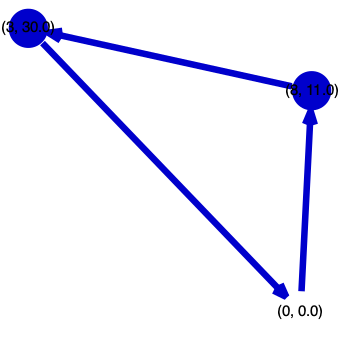

--------------------------------------------------------------------------------------------
t 3 : 


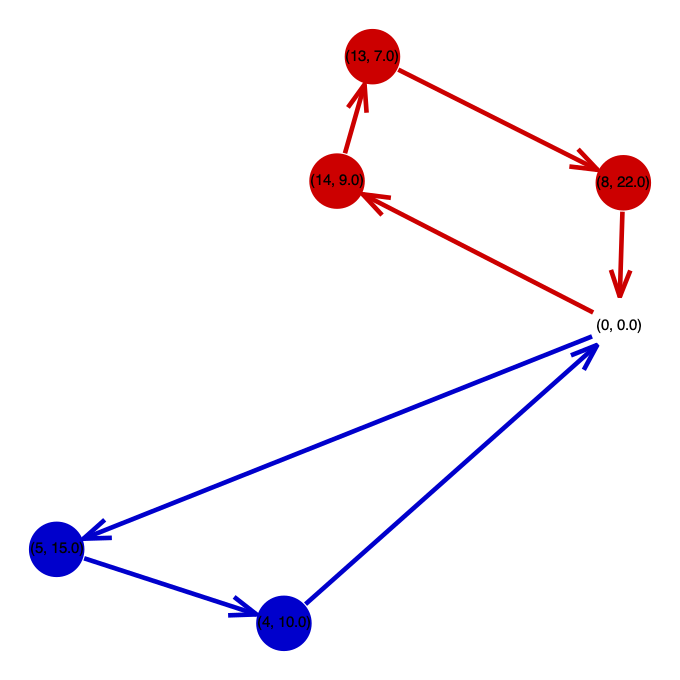

--------------------------------------------------------------------------------------------
t 4 : 


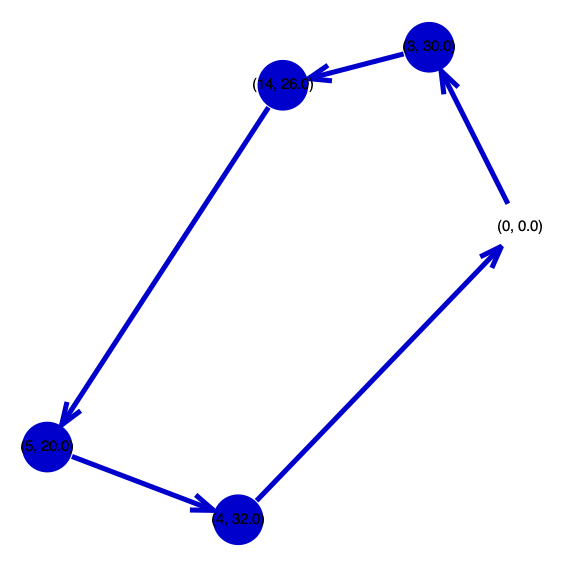

--------------------------------------------------------------------------------------------
t 5 : 


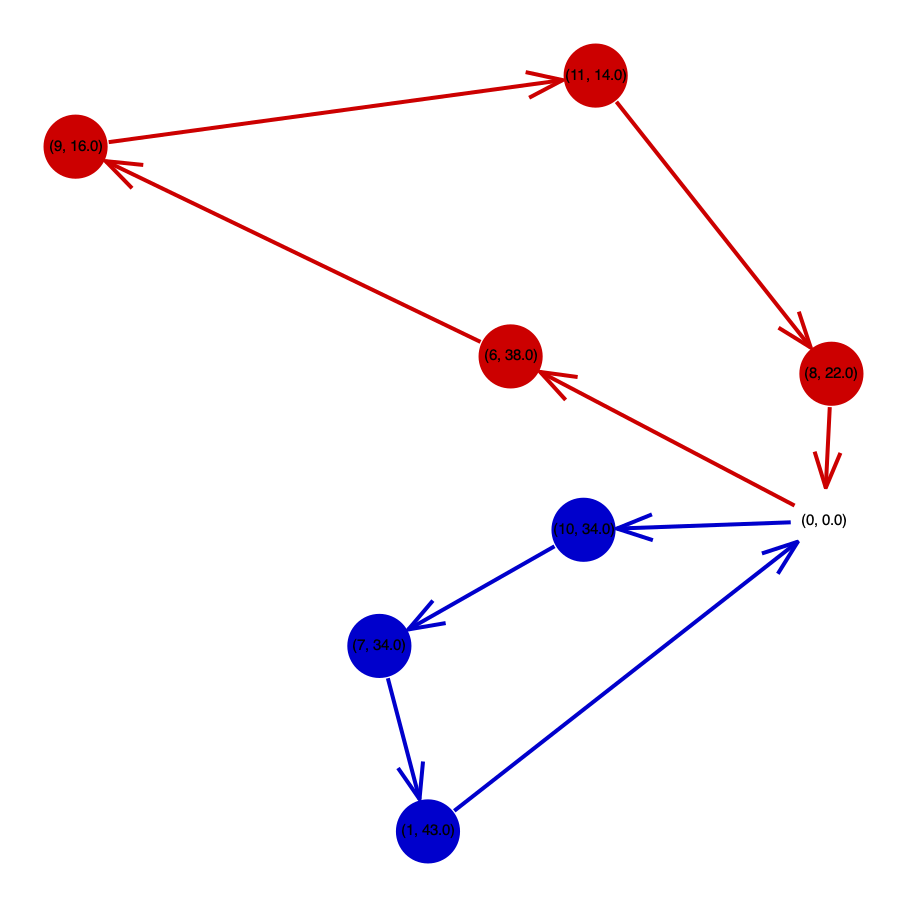

--------------------------------------------------------------------------------------------
t 6 : 


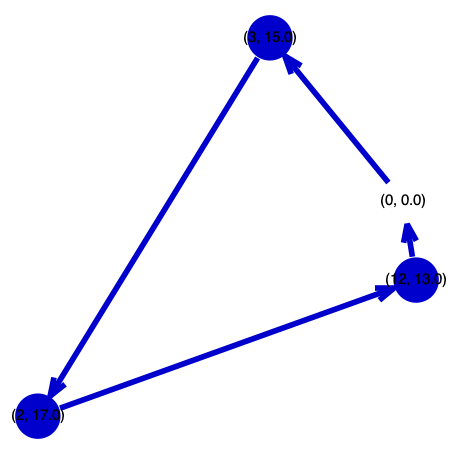

--------------------------------------------------------------------------------------------
Cost : 31408.000150937998


In [32]:
f = string(path, file, ".prp")
(cost, l), time_h = @timed PDI_H(f, h)
for t in 1:l
    t_file = "log/" * file * "/t_" * string(t) * ".png"
    if isfile(t_file)
        println("t " * string(t) * " : ")
        display("image/png", read(t_file))
        println("--------------------------------------------------------------------------------------------")
    end
end
println("Cost : " * string(cost))

In [33]:
println(string("Cout heuristique ", h, " : ", cost))
println(string("Temps d'exec heuristique ", h, " : ", time_h))

Cout heuristique CW : 31408.000150937998
Temps d'exec heuristique CW : 31.558664045


<h2>2. PLNE</h2>

In [49]:
include("src/PLNE/PDI_BC.jl")
include("src/readPRP.jl")

Read_PRP_instance (generic function with 2 methods)

In [7]:
#path = "PRP_instances/"
#file = "A_014_ABS1_15_3"
# file = "A_050_ABS7_50_5"
# file = "A_100_ABS94_100_1"
# file = "B_050_instance5"
# file = "B_200_instance16"

In [50]:
f = string(path, file, ".prp")
prp = Read_PRP_instance(f)
(p_dec, y_dec, I_dec, q_dec, x_dec, l, n, ccc), time_pl = @timed PDI_BC(prp)
q_dec = q_dec[2:end, 1:end]
println(string("temps exec : ", time_pl))

LoadError: MathOptInterface.UnsupportedAttribute{MathOptInterface.LazyConstraintCallback}: Attribute MathOptInterface.LazyConstraintCallback() is not supported by the model.

In [12]:
lots = []
graphs = []
for t in 1:l
    lot = []
    ii = 0
    for i in 1:n+1
        for j in 1:n+1
            if x_dec[i,j,t] == 1
                append!(lot, [(i, j)])
                ii = ii + 1
            end
        end
    end
    append!(lots, [lot])
    if ii != 0
        ll = Edge.(lot)
        g = SimpleDiGraph(ll)
        append!(graphs, [g])
    end
end

In [13]:
i = 1
t = 1
res = []
for lot in lots
    if length(lot) != 0
        c = simplecycles(graphs[i])
        for cycle in 1:length(c)
            for node in 1:length(c[cycle])
                c[cycle][node] -= 1
            end
        end
        i += 1
        append!(res, [c])
    else
        append!(res, [[]])
    end
    t += 1
end
print(res)

Any[Any[], [[0, 8, 3]], [[0, 4, 5, 14, 3, 8]], Any[], [[0, 10, 7, 2, 1, 4, 5, 9, 11, 13, 14, 6, 3, 8]], [[0, 12]]]

In [14]:
using Dates
include("src/draw.jl")
date, f_cost = string(Dates.now()), 0

for t in 1:l
    if res[t] != []
        pdi_to_png(prp, q_dec, t, res[t], file, date)
        f_cost += get_vrp_cost(prp, res[t])
    end
end

t 2 : 


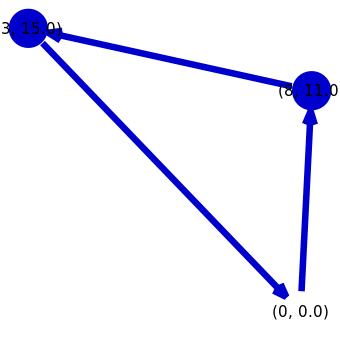

--------------------------------------------------------------------------------------------
t 3 : 


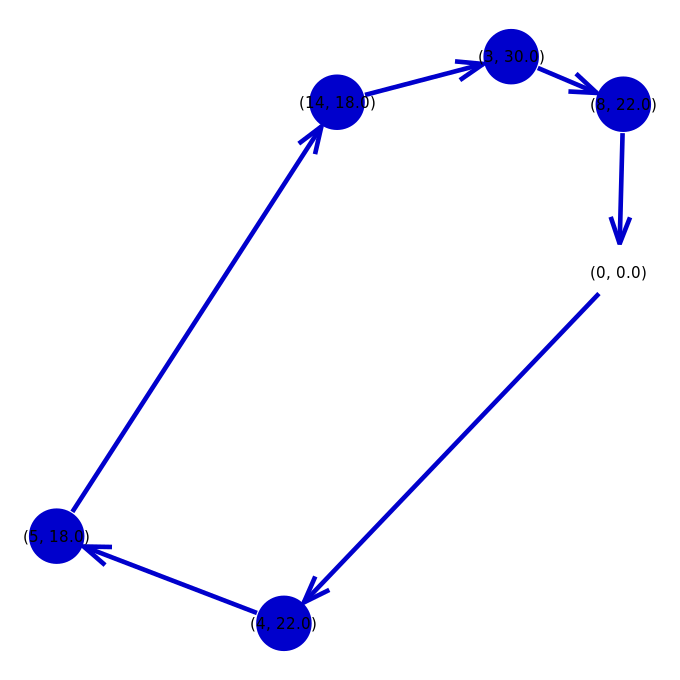

--------------------------------------------------------------------------------------------
t 5 : 


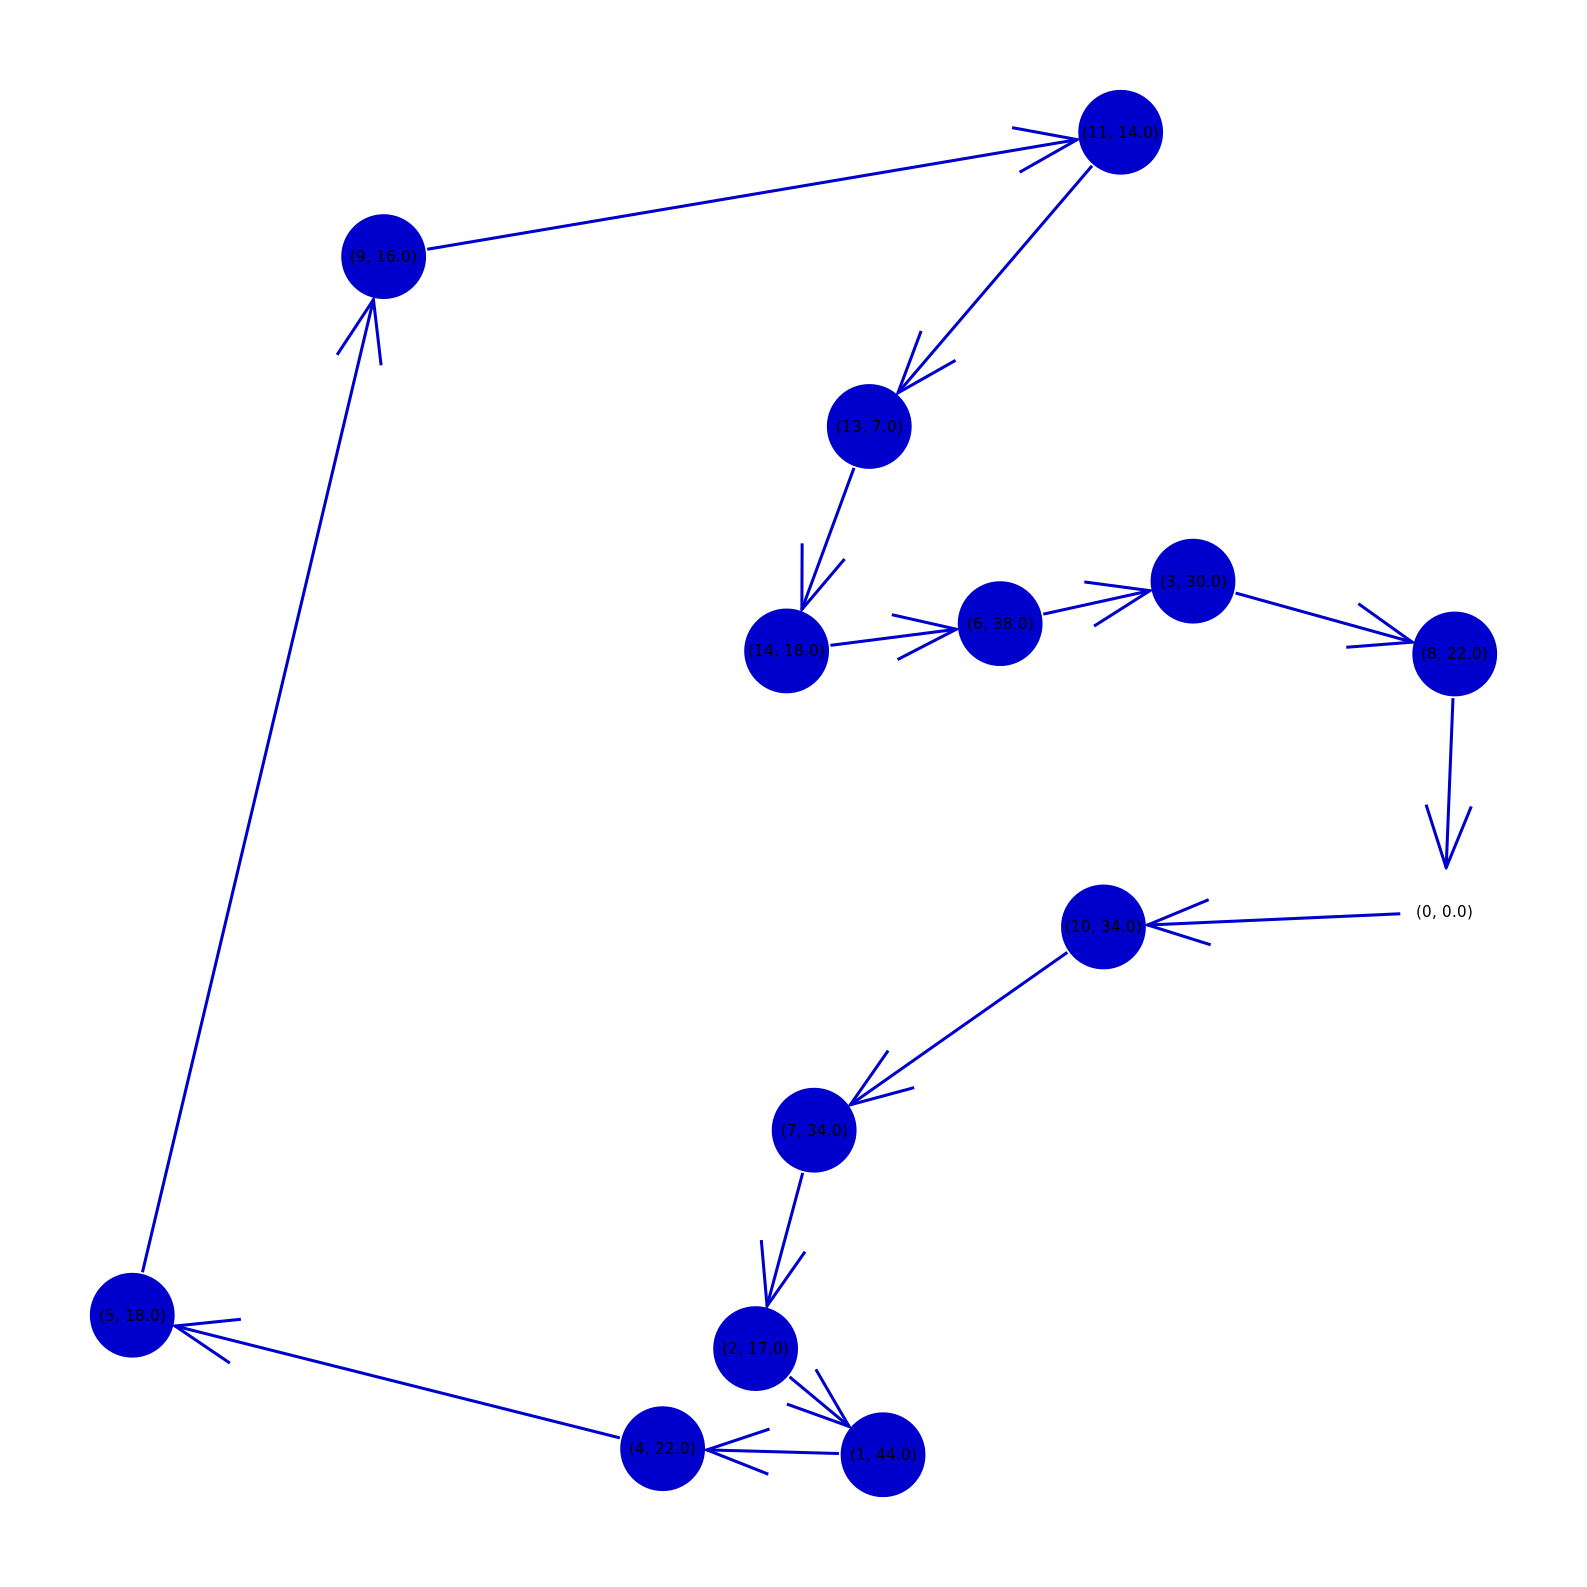

--------------------------------------------------------------------------------------------
t 6 : 


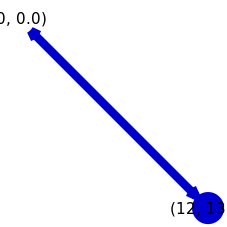

--------------------------------------------------------------------------------------------
Cost : 31107.0


In [15]:
for t in 1:l
    t_file = "log/" * file * "/t_" * string(t) * ".png"
    if isfile(t_file)
         println("t " * string(t) * " : ")
        display("image/png", read(t_file))
        println("--------------------------------------------------------------------------------------------")
    end
end
println(string("Cost : ", ccc))

In [16]:
println(string("Cost PLNE : ", ccc))
print(string("temps exec : ", time_pl))

Cost PLNE : 31107.0
temps exec : 37.937898284

<h2> Validation experimentale </h2>

<h3> 1.Comparaison de la performance des heuristiques et du PLNE </h3>

Pour les 3 heuristiques et le PLNE, on calcule les temps de calcul et les couts des solutions pour les instances de taille 14 (de 1 à 96)

In [ ]:
temps_CW=[]
temps_BP=[]
temps_SECT=[]
temps_PLNE=[]

cout_CW=[]
cout_BP=[]
cout_SECT=[]
cout_PLNE=[]


heuristiques = ["CW","BP","SECT"]
for classe in 1:96
    #calcul du cout et du tps de calcul avec les heuristiques
    for h in heuristiques 
        temps_moy=0
        cout_moy=0
        for j in 1:5
            
            file = string("A_014_ABS",i,"_15_",j)
            f = string(path, file, ".prp")
            (cost, l), time_h = @timed PDI_H(f, h)
            temps_moy = temps_moy+time_h/5
            cout_moy = cout_moy+cout/5

        end
        
        if h == "CW"
            append!(temps_CW,[temps_moy])
            append!(cout_CW,[cout_moy])
        end

        if h == "BP"
            append!(temps_BP,[temps_moy])
            append!(cout_BP,[cout_moy])
        end

        if h == "SECT"
            append!(temps_SECT,[temps_moy])
            append!(cout_SECT,[cout_moy])
        end
    end
    
    #calcul du cout et du tps de calcul avec le PLNE
    temps_moy=0
    cout_moy=0
    for j in 1:5
        file = string("A_014_ABS",i,"_15_",j)
        f = string(path, file, ".prp")
        (p_dec, y_dec, I_dec, q_dec, x_dec, l, n, ccc), time_pl = @timed PDI_BC(prp)
        temps_moy = temps_moy+time_pl/5
        cout_moy = cout_moy+ccc/5
    end
    
    append!(temps_PLNE,[temps_moy])
    append!(cout_PLNE,[cout_moy])
end

Pour chaque classe (I,II,III et IV), on affiche les temps de calcul et les couts de chaque heuristique/PLNE sous forme d'un point (xi,yi) où xi est le temps moyen de calcul sur les instances de taille 14 pour la classe i et yi le cout moyen.

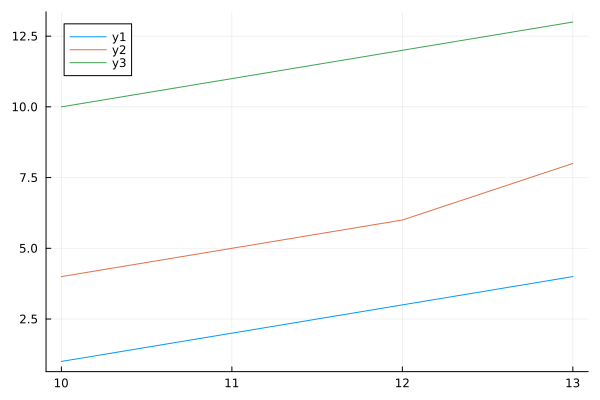

In [9]:

for classe in 1:4
    
    borne1 = 1+(classe-1)*24
    borne2 = borne1+24
    temps_CW_classe=0
    temps_BP_classe=0
    temps_SECT_classe=0
    temps_PLNE_classe=0

    cout_CW_classe=0
    cout_BP_classe=0
    cout_SECT_classe=0
    cout_PLNE_classe=0

    for i in borne1:borne2
        temps_CW_classe = temps_CW_classe + temps_CW[i]/23
        temps_BP_classe = temps_BP_classe + temps_BP[i]/23
        temps_SECT_classe = temps_SECT_classe + temps_SECT[i]/23
        temps_PLNE_classe = temps_PLNE_classe + temps_PLNE[i]/23

        cout_CW_classe = cout_CW_classe + cout_CW[i]/23
        cout_BP_classe = cout_BP_classe + cout_BP[i]/23
        cout_SECT_classe = cout_SECT_classe + cout_SECT[i]/23
        cout_PLNE_classe = cout_PLNE_classe + cout_PLNE[i]/23
    end

    x=[temps_CW_classe,temps_BP_classe,temps_SECT_classe,temps_PLNE_classe]
    y=[cout_CW_classe,cout_BP_classe,cout_SECT_classe,cout_PLNE_classe]
    scatter(x,y,series_annotations = ["CW","BP","SECT","PLNE"],title=string("Classe ",classe))
end
